In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import argparse

import os
import random
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from config import parse_args_ddqn,parse_global_args, get_sweep_params, get_shock_params
from dqn.dqn_runner import evaluate_policy, UpdateCartpoleParams, UpdateAcrobotParams, UpdateMountaincarParams
from dqn.dqn_visualize import evaluate_shock_matrix, LoadModel
from dqn.dqn import DQN_Agent

In [4]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [5]:
parent = argparse.ArgumentParser()
global_parser = parse_global_args(parent)
ddqn_parser = parse_args_ddqn(global_parser)

In [13]:
cartpole_convergence = os.path.abspath(os.path.join('..', '..', 'wandb_plots_csv', 'cartpole_convergence_full.csv'))
acrobot_convergence = os.path.abspath(os.path.join('..', '..', 'wandb_plots_csv', 'acrobot_convergence_full.csv'))
mountaincar_convergence = os.path.abspath(os.path.join('..', '..', 'wandb_plots_csv', 'mountaincar_convergence_full.csv'))

In [14]:
cartpole_convergence_raw = pd.read_csv(cartpole_convergence)
acrobot_convergence_raw = pd.read_csv(acrobot_convergence)
mountaincar_convergence_raw = pd.read_csv(mountaincar_convergence)

In [15]:
cartpole_convergence_raw

,Step,chocolate-sweep-145 - score,chocolate-sweep-145 - score__MIN,chocolate-sweep-145 - score__MAX,stilted-sweep-142 - score,stilted-sweep-142 - score__MIN,stilted-sweep-142 - score__MAX,peachy-sweep-141 - score,peachy-sweep-141 - score__MIN,peachy-sweep-141 - score__MAX,...,bright-sweep-14 - score__MAX,woven-sweep-13 - score,woven-sweep-13 - score__MIN,woven-sweep-13 - score__MAX,wise-sweep-4 - score,wise-sweep-4 - score__MIN,wise-sweep-4 - score__MAX,radiant-sweep-3 - score,radiant-sweep-3 - score__MIN,radiant-sweep-3 - score__MAX
0,0,24,24,24,9,9,9,30,30,30,...,9,9,9,9,23,23,23,9,9,9
1,42,216,216,216,340,340,340,179,179,179,...,220,219,219,219,438,438,438,224,224,224
2,143,244,244,244,219,219,219,357,357,357,...,293,268,268,268,379,379,379,262,262,262
3,244,247,247,247,198,198,198,194,194,194,...,329,298,298,298,330,330,330,245,245,245
4,345,233,233,233,209,209,209,250,250,250,...,270,313,313,313,311,311,311,260,260,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,11657,455,455,455,421,421,421,500,500,500,...,500,500,500,500,479,479,479,500,500,500
117,11758,461,461,461,500,500,500,500,500,500,...,500,497,497,497,445,445,445,500,500,500
118,11859,264,264,264,355,355,355,500,500,500,...,500,500,500,500,458,458,458,500,500,500
119,11960,473,473,473,463,463,463,500,500,500,...,500,500,500,500,473,473,473,500,500,500


In [20]:
def calculate_mean_std(df, columns):
    series_list = []
    for column_name in columns:
        series_list.append(df[column_name])

    numpy_arr = np.array(series_list).T
    mean_arr = np.mean(numpy_arr, axis=1)
    std_arr = np.std(numpy_arr, axis=1)
    return mean_arr, std_arr

In [21]:
# Cartpole
model_subfolder = 'vanilla_cartpole_reduleLR_scheduler1_5e5_ema'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
vanilla_cp_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

model_subfolder = 'R2_cartpole_reduleLR_scheduler1_5e5_ema'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
r2_cp_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

model_subfolder = 'ro_cartpole_sweep'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
robust_cp_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

mean_cp_vanilla, std_cp_vanilla = calculate_mean_std(df=cartpole_convergence_raw, columns=vanilla_cp_columns)
mean_cp_r2, std_cp_r2 = calculate_mean_std(df=cartpole_convergence_raw, columns=r2_cp_columns)
mean_cp_robust, std_cp_robust = calculate_mean_std(df=cartpole_convergence_raw, columns=robust_cp_columns)

cartpole_df = pd.DataFrame()
cartpole_df['Step'] = cartpole_convergence_raw['Step'] * 50

cartpole_df['mean_cp_vanilla'] = mean_cp_vanilla
cartpole_df['min_cp_vanilla'] = mean_cp_vanilla - std_cp_vanilla
cartpole_df['max_cp_vanilla'] = mean_cp_vanilla + std_cp_vanilla

cartpole_df['mean_cp_r2'] = mean_cp_r2
cartpole_df['min_cp_r2'] = mean_cp_r2 - std_cp_r2
cartpole_df['max_cp_r2'] = mean_cp_r2 + std_cp_r2

cartpole_df['mean_cp_robust'] = mean_cp_robust
cartpole_df['min_cp_robust'] = mean_cp_robust - std_cp_robust
cartpole_df['max_cp_robust'] = mean_cp_robust + std_cp_robust

for column in cartpole_df.columns:
    if column != 'Step':
        cartpole_df.loc[:, column] = cartpole_df[column].apply(lambda x: x if x < 500 else 500)
        cartpole_df.loc[:, column] = cartpole_df[column].apply(lambda x: x if x > 0 else 0)

In [22]:
# Acrobot
model_subfolder = 'vanilla_acrobot_sweep'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
vanilla_ac_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

model_subfolder = 'r2_acrobot_sweep'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
r2_ac_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

model_subfolder = 'ro_acrobot_sweep'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
robust_ac_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

mean_ac_vanilla, std_ac_vanilla = calculate_mean_std(df=acrobot_convergence_raw, columns=vanilla_ac_columns)
mean_ac_r2, std_ac_r2 = calculate_mean_std(df=acrobot_convergence_raw, columns=r2_ac_columns)
mean_ac_robust, std_ac_robust = calculate_mean_std(df=acrobot_convergence_raw, columns=robust_ac_columns)

acrobot_df = pd.DataFrame()
acrobot_df['Step'] = acrobot_convergence_raw['Step'] * 50

acrobot_df['mean_ac_vanilla'] = mean_ac_vanilla
acrobot_df['min_ac_vanilla'] = mean_ac_vanilla - std_ac_vanilla
acrobot_df['max_ac_vanilla'] = mean_ac_vanilla + std_ac_vanilla

acrobot_df['mean_ac_r2'] = mean_ac_r2
acrobot_df['min_ac_r2'] = mean_ac_r2 - std_ac_r2
acrobot_df['max_ac_r2'] = mean_ac_r2 + std_ac_r2

acrobot_df['mean_ac_robust'] = mean_ac_robust
acrobot_df['min_ac_robust'] = mean_ac_robust - std_ac_robust
acrobot_df['max_ac_robust'] = mean_ac_robust + std_ac_robust

for column in acrobot_df.columns:
    acrobot_df.loc[:, column] = acrobot_df[column].apply(lambda x: x if x > -500 else -500)

In [23]:
# Mountain car
model_subfolder = 'vanilla_mountaincar_sweep'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
vanilla_mc_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

model_subfolder = 'r2_mountaincar_sweep'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
r2_mc_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]

model_subfolder = 'ro_mountaincar_sweep'
model_name = os.listdir(os.path.abspath(os.path.join('dqn', 'model', model_subfolder)))
robust_mc_columns = [x.split('_')[-1].split('.')[0] + ' - score' for x in model_name]


mean_mc_vanilla, std_mc_vanilla = calculate_mean_std(df=mountaincar_convergence_raw, columns=vanilla_mc_columns)
mean_mc_r2, std_mc_r2 = calculate_mean_std(df=mountaincar_convergence_raw, columns=r2_mc_columns)
mean_mc_robust, std_mc_robust = calculate_mean_std(df=mountaincar_convergence_raw, columns=robust_mc_columns)

mountain_df = pd.DataFrame()
mountain_df['Step'] = mountaincar_convergence_raw['Step'] * 50

mountain_df['mean_mc_vanilla'] = mean_mc_vanilla
mountain_df['min_mc_vanilla'] = mean_mc_vanilla - std_mc_vanilla
mountain_df['max_mc_vanilla'] = mean_mc_vanilla + std_mc_vanilla

mountain_df['mean_mc_r2'] = mean_mc_r2
mountain_df['min_mc_r2'] = mean_mc_r2 - std_mc_r2
mountain_df['max_mc_r2'] = mean_mc_r2 + std_mc_r2

mountain_df['mean_mc_robust'] = mean_mc_robust
mountain_df['min_mc_robust'] = mean_mc_robust - std_mc_robust
mountain_df['max_mc_robust'] = mean_mc_robust + std_mc_robust

for column in mountain_df.columns:
    mountain_df.loc[:, column] = mountain_df[column].apply(lambda x: x if x > -200 else -200)

In [26]:
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'same') / n

def numpy_ewma_vectorized(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [25]:
# vanilla_cp_rew = cartpole_convergence_raw['algo_type: DDQN - score']
# vanilla_cp_min = cartpole_convergence_raw['algo_type: DDQN - score__MIN']
# vanilla_cp_max = cartpole_convergence_raw['algo_type: DDQN - score__MAX']

# robust_cp_rew = cartpole_convergence_raw['algo_type: RO_DDQN - score']
# robust_cp_min = cartpole_convergence_raw['algo_type: RO_DDQN - score__MIN']
# robust_cp_max = cartpole_convergence_raw['algo_type: RO_DDQN - score__MAX']

# r2_cp_rew = cartpole_convergence_raw['algo_type: R2_DDQN - score']
# r2_cp_min = cartpole_convergence_raw['algo_type: R2_DDQN - score__MIN']
# r2_cp_max = cartpole_convergence_raw['algo_type: R2_DDQN - score__MAX']

<Figure size 640x480 with 0 Axes>

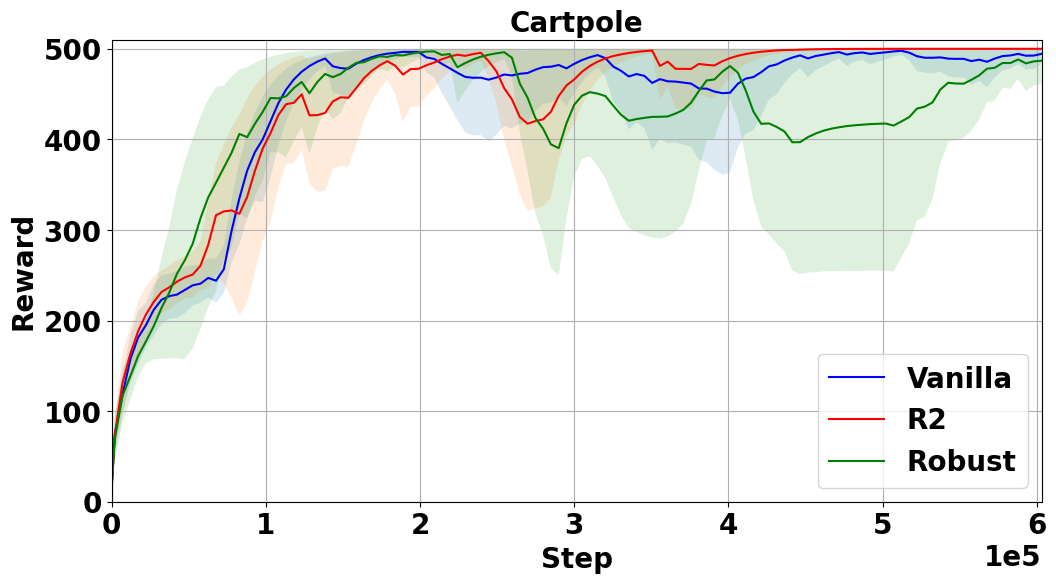

In [31]:
step = cartpole_df['Step']
vanilla_cp_rew = cartpole_df['mean_cp_vanilla']
vanilla_cp_min = cartpole_df['min_cp_vanilla']
vanilla_cp_max = cartpole_df['max_cp_vanilla']

robust_cp_rew = cartpole_df['mean_cp_robust']
robust_cp_min = cartpole_df['min_cp_robust']
robust_cp_max = cartpole_df['max_cp_robust']

r2_cp_rew = cartpole_df['mean_cp_r2']
r2_cp_min = cartpole_df['min_cp_r2']
r2_cp_max = cartpole_df['max_cp_r2']
#########################################################################
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20

n=7
vanilla_cp_rew = numpy_ewma_vectorized(vanilla_cp_rew.values, window=n)
vanilla_cp_min = numpy_ewma_vectorized(vanilla_cp_min.values, window=n)
vanilla_cp_max = numpy_ewma_vectorized(vanilla_cp_max.values, window=n)

r2_cp_rew = numpy_ewma_vectorized(r2_cp_rew.values, window=n)
r2_cp_min = numpy_ewma_vectorized(r2_cp_min.values, window=n)
r2_cp_max = numpy_ewma_vectorized(r2_cp_max.values, window=n)

robust_cp_rew = numpy_ewma_vectorized(robust_cp_rew.values, window=n)
robust_cp_min = numpy_ewma_vectorized(robust_cp_min.values, window=n)
robust_cp_max = numpy_ewma_vectorized(robust_cp_max.values, window=n)


ax.plot(step, vanilla_cp_rew,'b', label='Vanilla') 
ax.fill_between(step, vanilla_cp_min, vanilla_cp_max, alpha=0.15)

ax.plot(step, r2_cp_rew,'r', label='R2') 
ax.fill_between(step, r2_cp_min, r2_cp_max, alpha=0.15)

ax.plot(step, robust_cp_rew,'g', label='Robust')
ax.fill_between(step, robust_cp_min, robust_cp_max, alpha=0.15)

    
ax.invert_xaxis()
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('Reward', fontsize=fontsize)
ax.set_title('Cartpole', fontweight="bold", fontsize=fontsize)
ax.set_xlim(np.min(step),np.max(step))
# ax.set_xlim(1, 10)
ax.set_yticks(range(0,510,100))
ax.set_ylim([0, 510])
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.tick_params(axis='both', labelsize=fontsize)
ax.xaxis.get_offset_text().set_fontsize(fontsize)

plt.axvline(x=0.001, c='black')

ax.grid(True)
ax.legend(prop={'size': fontsize})

plt.savefig(os.path.abspath('../plots/wandbfixed_cartpole_convergence.png'))

<Figure size 640x480 with 0 Axes>

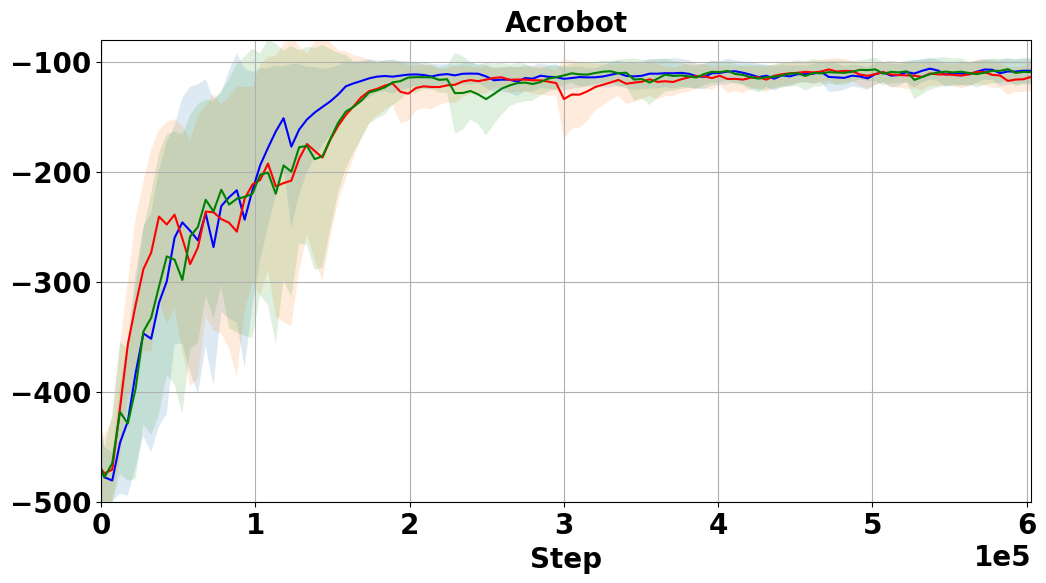

In [43]:
step = acrobot_df['Step']
vanilla_ac_rew = acrobot_df['mean_ac_vanilla']
vanilla_ac_min = acrobot_df['min_ac_vanilla']
vanilla_ac_max = acrobot_df['max_ac_vanilla']

robust_ac_rew = acrobot_df['mean_ac_robust']
robust_ac_min = acrobot_df['min_ac_robust']
robust_ac_max = acrobot_df['max_ac_robust']

r2_ac_rew = acrobot_df['mean_ac_r2']
r2_ac_min = acrobot_df['min_ac_r2']
r2_ac_max = acrobot_df['max_ac_r2']
#########################################################################
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20

n=7
vanilla_ac_rew = numpy_ewma_vectorized(vanilla_ac_rew.values, window=n)
vanilla_ac_min = numpy_ewma_vectorized(vanilla_ac_min.values, window=n)
vanilla_ac_max = numpy_ewma_vectorized(vanilla_ac_max.values, window=n)

r2_ac_rew = numpy_ewma_vectorized(r2_ac_rew.values, window=n)
r2_ac_min = numpy_ewma_vectorized(r2_ac_min.values, window=n)
r2_ac_max = numpy_ewma_vectorized(r2_ac_max.values, window=n)

robust_ac_rew = numpy_ewma_vectorized(robust_ac_rew.values, window=n)
robust_ac_min = numpy_ewma_vectorized(robust_ac_min.values, window=n)
robust_ac_max = numpy_ewma_vectorized(robust_ac_max.values, window=n)


ax.plot(step, vanilla_ac_rew,'b', label='Vanilla') 
ax.fill_between(step, vanilla_ac_min, vanilla_ac_max, alpha=0.15)

ax.plot(step, r2_ac_rew,'r', label='R2') 
ax.fill_between(step, r2_ac_min, r2_ac_max, alpha=0.15)

ax.plot(step, robust_ac_rew,'g', label='Robust')
ax.fill_between(step, robust_ac_min, robust_ac_max, alpha=0.15)

    
ax.invert_xaxis()
ax.set_xlabel('Step', fontsize=fontsize)
# ax.set_ylabel('Reward', fontsize=fontsize)
ax.set_title('Acrobot', fontweight="bold", fontsize=fontsize)
ax.set_xlim(np.min(step),np.max(step))
ax.set_yticks(range(-500,-80,100))
ax.set_ylim([-500, -80])
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.tick_params(axis='both', labelsize=fontsize)
ax.xaxis.get_offset_text().set_fontsize(fontsize)
plt.axvline(x=0.001, c='black')

ax.grid(True)
# ax.legend(fontsize=15)

plt.savefig(os.path.abspath('../plots/wandbfixed_acrobot_convergence.png'))

<Figure size 640x480 with 0 Axes>

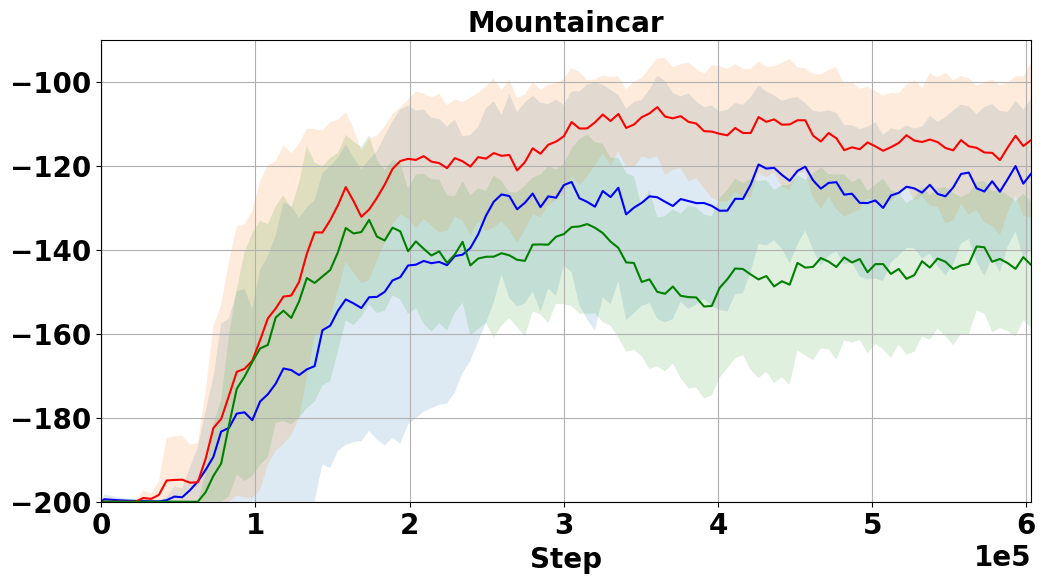

In [44]:
step = mountain_df['Step']
vanilla_mc_rew = mountain_df['mean_mc_vanilla']
vanilla_mc_min = mountain_df['min_mc_vanilla']
vanilla_mc_max = mountain_df['max_mc_vanilla']

robust_mc_rew = mountain_df['mean_mc_robust']
robust_mc_min = mountain_df['min_mc_robust']
robust_mc_max = mountain_df['max_mc_robust']

r2_mc_rew = mountain_df['mean_mc_r2']
r2_mc_min = mountain_df['min_mc_r2']
r2_mc_max = mountain_df['max_mc_r2']
#########################################################################
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 20
n=7
vanilla_mc_rew = numpy_ewma_vectorized(vanilla_mc_rew.values, window=n)
vanilla_mc_min = numpy_ewma_vectorized(vanilla_mc_min.values, window=n)
vanilla_mc_max = numpy_ewma_vectorized(vanilla_mc_max.values, window=n)

r2_mc_rew = numpy_ewma_vectorized(r2_mc_rew.values, window=n)
r2_mc_min = numpy_ewma_vectorized(r2_mc_min.values, window=n)
r2_mc_max = numpy_ewma_vectorized(r2_mc_max.values, window=n)

robust_mc_rew = numpy_ewma_vectorized(robust_mc_rew.values, window=n)
robust_mc_min = numpy_ewma_vectorized(robust_mc_min.values, window=n)
robust_mc_max = numpy_ewma_vectorized(robust_mc_max.values, window=n)


ax.plot(step, vanilla_mc_rew,'b', label='Vanilla') 
ax.fill_between(step, vanilla_mc_min, vanilla_mc_max, alpha=0.15)

ax.plot(step, r2_mc_rew,'r', label='R2') 
ax.fill_between(step, r2_mc_min, r2_mc_max, alpha=0.15)

ax.plot(step, robust_mc_rew,'g', label='Robust')
ax.fill_between(step, robust_mc_min, robust_mc_max, alpha=0.15)

    
ax.invert_xaxis()
ax.set_xlabel('Step', fontsize=fontsize)
# ax.set_ylabel('Reward', fontsize=fontsize)
ax.set_title('Mountaincar', fontweight="bold", fontsize=fontsize)
ax.set_xlim(np.min(step),np.max(step))
ax.set_yticks(range(-200,-80,20))
ax.set_ylim([-200, -90])
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.tick_params(axis='both', labelsize=fontsize)
ax.xaxis.get_offset_text().set_fontsize(fontsize)
plt.axvline(x=0.001, c='black')

ax.grid(True)
# ax.legend(fontsize=15)

plt.savefig(os.path.abspath('../plots/wandbfixed_mountaincar_convergence.png'))

<Figure size 640x480 with 0 Axes>

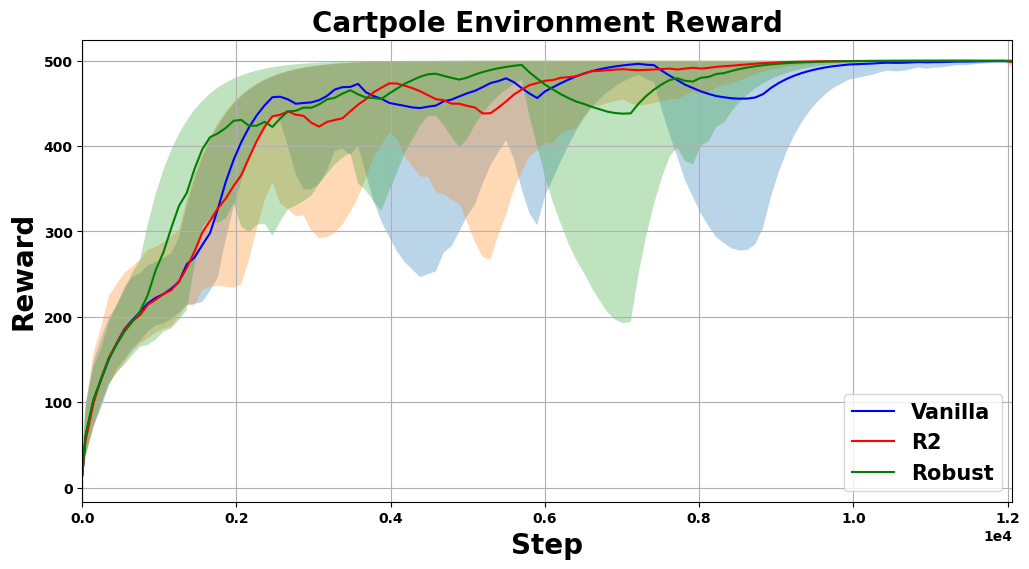

In [73]:
plt.clf()
fig, ax = plt.subplots(figsize=(12, 6))

n=10
vanilla_cp_rew = numpy_ewma_vectorized(vanilla_cp_rew.values, window=n)
vanilla_cp_min = numpy_ewma_vectorized(vanilla_cp_min.values, window=n)
vanilla_cp_max = numpy_ewma_vectorized(vanilla_cp_max.values, window=n)

r2_cp_rew = numpy_ewma_vectorized(r2_cp_rew.values, window=n)
r2_cp_min = numpy_ewma_vectorized(r2_cp_min.values, window=n)
r2_cp_max = numpy_ewma_vectorized(r2_cp_max.values, window=n)

robust_cp_rew = numpy_ewma_vectorized(robust_cp_rew.values, window=n)
robust_cp_min = numpy_ewma_vectorized(robust_cp_min.values, window=n)
robust_cp_max = numpy_ewma_vectorized(robust_cp_max.values, window=n)


ax.plot(step, vanilla_cp_rew,'b', label='Vanilla') 
ax.fill_between(step, vanilla_cp_min, vanilla_cp_max, alpha=0.3)

ax.plot(step, r2_cp_rew,'r', label='R2') 
ax.fill_between(step, r2_cp_min, r2_cp_max, alpha=0.3)

ax.plot(step, robust_cp_rew,'g', label='Robust')
ax.fill_between(step, robust_cp_min, robust_cp_max, alpha=0.3)

    
ax.invert_xaxis()
ax.set_xlabel('Step', fontsize=20)
ax.set_ylabel('Reward', fontsize=20)
ax.set_title('Cartpole Environment Reward', fontweight="bold", fontsize=20)
ax.set_xlim(np.min(step),np.max(step))
# ax.set_xlim(1, 10)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.axvline(x=0.001, c='black')

ax.grid(True)
ax.legend(fontsize=15)

plt.savefig(os.path.abspath('../plots/wandbfixed_cartpole_convergence.png'))